<a href="https://colab.research.google.com/github/GeorgesBongibault/Project-Orange/blob/main/DMML_Team_Orange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning Project : Group Orange
####Diana Korka, Georges Bongibault, Thomas Tabernero
Given tweets on the subject of disasters, we will build Machine Learning models that should predict which tweets are about a real disaster and which are not.
##Table of contents:
> 1. Exploratory Data Analysis
> 2. First classifier: Logistic Regression
> 3. First ideas for improving accuracy
> 4. Second classifier: Random forest
> 5. Third classifier: K-Nearest Neighbours
> 6. Dimension Reduction and Feature Engineering
> 7. Further improvements

###Useful importations


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
!python -m spacy download en
import spacy
from spacy.language import Language
from spacy.lang.en import English
import string
from sklearn.model_selection import GridSearchCV

sns.set_style("white")
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


### Load the Data

We will use the training_data dataset from our Github repository (https://github.com/GeorgesBongibault/Project-Orange). This dataset contains some information about tweets related to disasters.
The features of the dataset are :

> 1. `id` : the personnal identificational number of the tweet.
> 2. `keyword` : what the tweet is about
> 3. `location` : where the tweet is from
> 4. `text`: the entire tweet
> 5. `target` : true disaster (1) or not (0)

Our task is to predict which tweets are about a real disaster and which are not.

We load and save the test set for later.

In [ ]:
test_df = pd.read_csv('https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Data/test_data.csv')

Let's take a look at our dataset.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Data/training_data.csv")
df.head(27)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
5,6669,landslide,Scotland,FreeBesieged: .MartinMJ22 YouGov Which '#Tory ...,1
6,9772,trapped,New York City,Billionaires have a plan to free half a billio...,0
7,10361,weapons,Multinational *****,@JamesMelville Some old testimony of weapons u...,0
8,1953,burning%20buildings,Los Angeles,Ali you flew planes and ran into burning build...,0
9,9586,thunder,NaN,The thunder shook my house woke my sister and ...,1


In [ ]:
print("There are", df.shape[0],"rows and",df.shape[1], "columns in this dataset")

There are 6471 rows and 5 columns in this dataset


##1. Exploratory Data Analysis


### Base rate
Let's compute the base rate and see the repartition of our data set.

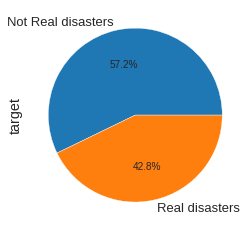

In [ ]:
label = 'Not Real disasters', 'Real disasters'
df.target.value_counts().plot(kind='pie',autopct='%1.1f%%', labels = label)
plt.show()

In [ ]:
l_false = len(df[df["target"] == 0])
l_true = len(df[df["target"] == 1])
print("We have a base rate of",round(max(l_false, l_true)/df.shape[0],4),"and the most common class is the false disasters, with", l_false, "occurences.")

We have a base rate of 0.5719 and the most common class is the false disasters, with 3701 occurences.


Our data is well balanced between both classes, the accuracy will therefore be a good indicator of the robustness of our model.

### Description of variables :

Description of the variable "keyword" :

In [ ]:
df.keyword.describe()

count       6416
unique       221
top       deluge
freq          39
Name: keyword, dtype: object

Description of the variable "location" :

In [ ]:
df.location.describe()

count     4330
unique    2921
top        USA
freq        91
Name: location, dtype: object

There are 221 unique keywords and 2921 unique locations. \\
Let's have a look about the occurence of fake tweets related to their location and keyword.


For every keyword we plot the occurence of real and fake disasters.

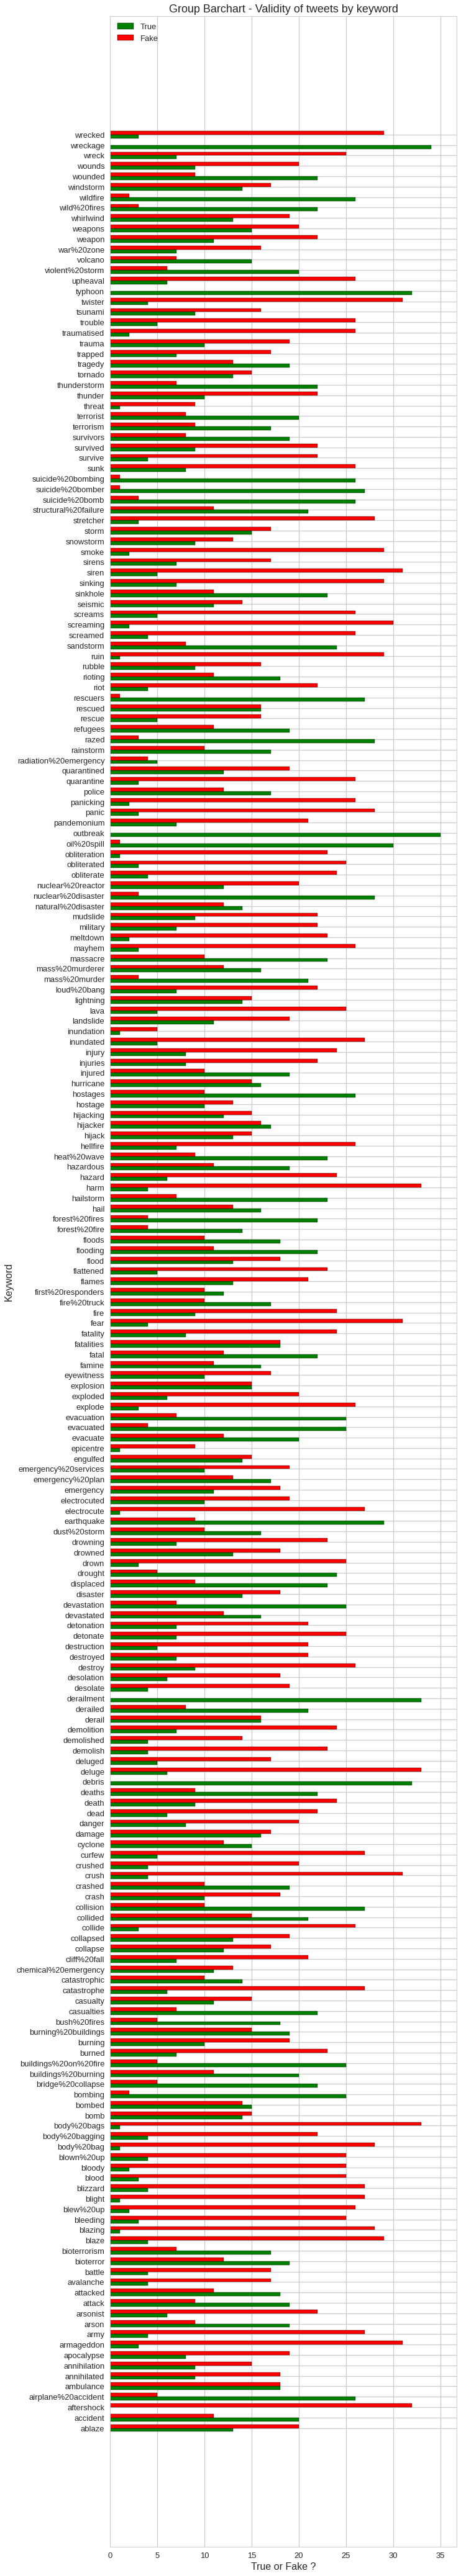

In [ ]:
a = df.copy()
a['target neg'] = 1 - a['target']
a["location"] = a["location"]
data = a.groupby("keyword", as_index=False)[['target', 'target neg']].sum()

x = data["keyword"]
y = data["target"]
z = data["target neg"]

validity=['True','Fake']
pos = np.arange(len(x))

fig = plt.figure(1, figsize=(10, 75))
bar_width = 0.35

plt.barh(pos-bar_width/2,y,bar_width,color='green',edgecolor='black')
plt.barh(pos+bar_width/2,z,bar_width,color='red',edgecolor='black')
plt.yticks(pos, x)

plt.ylabel('Keyword', fontsize=16)
plt.xlabel('True or Fake ?', fontsize=16)
plt.title('Group Barchart - Validity of tweets by keyword',fontsize=18)
plt.legend(validity,loc=2)

plt.show()

Here are the 15 most common locations for true and fake tweets about a disaster:

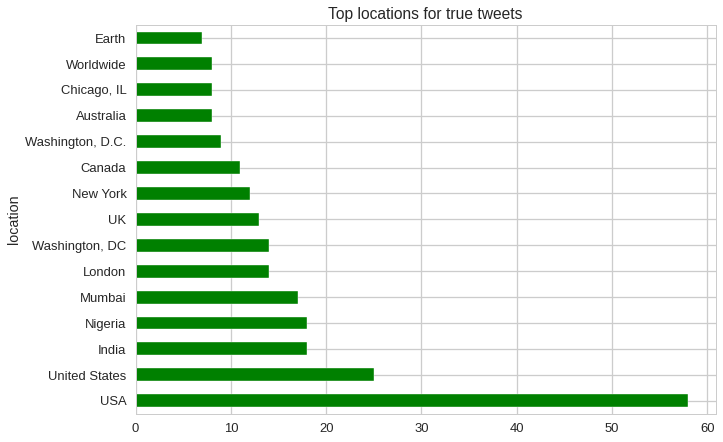

In [ ]:
a = df.copy()
a['target neg'] = 1 - a['target']
data = a[['location','target', 'target neg']].groupby(['location']).sum()
data.nlargest(15, "target").plot(kind = 'barh', y = 'target', ylabel = 'Number of true tweets', title = "Top locations for true tweets", legend = False, color = 'g')

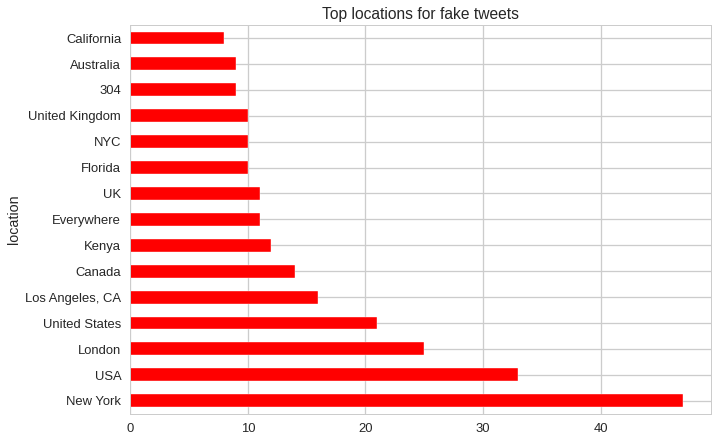

In [ ]:
data.nlargest(15, "target neg").plot(kind = 'barh', y = 'target neg',ylabel = 'Number of fake tweets', title = "Top locations for fake tweets", legend = False, color = 'r')

Here are the 15 most common keywords for true and fake tweets about a disaster:

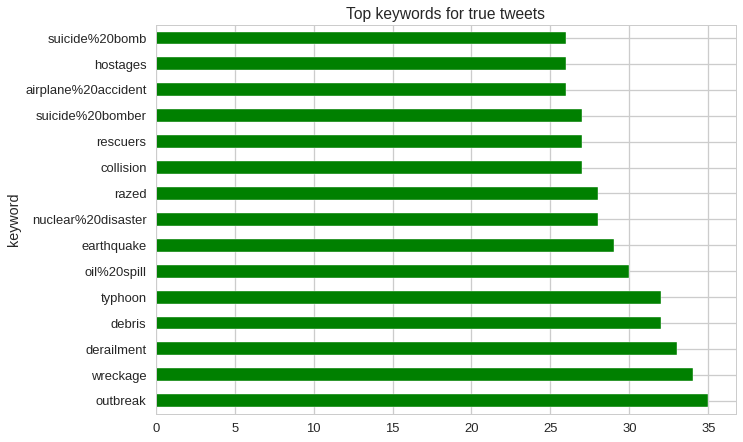

In [ ]:
a = df.copy()
a['target neg'] = 1 - a['target']
data = a[['keyword','target', 'target neg']].groupby(['keyword']).sum()
data.nlargest(15, "target").plot(kind = 'barh', y = 'target',ylabel = 'Number of true tweets', title = "Top keywords for true tweets", legend = False, color = 'g')

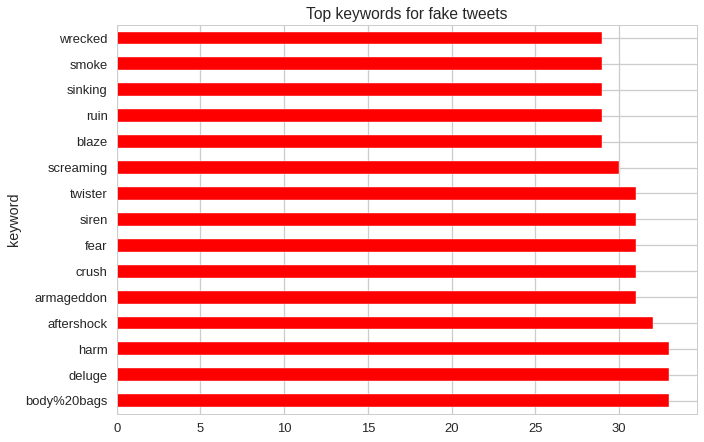

In [ ]:
data.nlargest(15, "target neg").plot(kind = 'barh', y = 'target neg', ylabel = 'Number of fake tweets', title = "Top keywords for fake tweets", legend = False,  color = 'r')

Description of the variable "id":

In [ ]:
df.id.describe()

count     6471.000000
mean      5446.289600
std       3139.343612
min          1.000000
25%       2731.000000
50%       5450.000000
75%       8161.500000
max      10873.000000
Name: id, dtype: float64

Description of the variable "text":

In [ ]:
df.text.describe()

count                                                  6471
unique                                                 6387
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                      9
Name: text, dtype: object

We can see that there is no problem with the id, every number is unique but we 
can see that some tweets appear several times, we may therefore have to eliminate duplicates to avoid weighting problems

## 2. First classifier: Logistic Regression 


Firstly we use the entire data and don't do any feature engineering.
We start with the basics: we split our data into train and test sets, then preprocess the tweets, and train a logistic regression on the training set.



We will need to evaluate our models:

In [ ]:
# A useful function for the future evaluations of our models
def evaluate(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"Confusion Matrix:\n{confusion_matrix(true, pred)}")
    print(f"Accuracy Score:\n{accuracy_score(true, pred):.4f}")
    print(f"Classification Report:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

We split our data into train and test sets...

In [ ]:
# Select features
X = df.text
y = df.target

In [ ]:
#We fix the random state for future comparisons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)
print(X_train.values[8])
print("The target is",y_train.values[8], ", this isn't fake news!")

[JAX Biz Journal] FedEx stops shipping potential bioterror pathogens http://t.co/R33nCvjovC
The target is 1 , this isn't fake news!


...Then preprocess the tweets...

In [ ]:
sp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
numbers = "0123456789"

In [ ]:
def spacy_tokenizer(text):
    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words, numbers and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations and word not in numbers ]

    # Remove usernames and hashtags
    mytokens_2 = []
    for word in mytokens:
      i = False
      for letter in word :
        if letter == '@' or letter == '#':
            i = True
      if not(i) :
        mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

In [ ]:
spacy_tokenizer(X_train.values[8])

['jax',
 'biz',
 'journal',
 'fedex',
 'stop',
 'ship',
 'potential',
 'bioterror',
 'pathogen',
 'http://t.co/r33ncvjovc']

...And train a logistic regression (on the training part), with TF-IDF .

In [ ]:
# version 0: TFIDF, logistic regression without cross validation
# Define the vectorizer
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)

# Define the classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=2000)

# Create pipeline
pipe0 = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe0.fit(X_train, y_train)

#Evaluate
y_train_pred = pipe0.predict(X_train)
y_test_pred = pipe0.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2872   82]
 [ 488 1734]]
ACCURACY SCORE:
0.8899
CLASSIFICATION REPORT:
	Precision: 0.9548
	Recall: 0.7804
	F1_Score: 0.8588
Validation Set: 
CONFUSION MATRIX:
[[672  75]
 [170 378]]
ACCURACY SCORE:
0.8108
CLASSIFICATION REPORT:
	Precision: 0.8344
	Recall: 0.6898
	F1_Score: 0.7552


In [ ]:
#Version 1:TFIDF, logistic regression with cross validation
# Define the vectorizer
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)

# Define the classifier
classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=2000)

# Create pipeline
pipe1 = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])
# Fit model on training set
pipe1.fit(X_train, y_train)

#Evaluate
y_train_pred = pipe1.predict(X_train)
y_test_pred = pipe1.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2892   62]
 [ 242 1980]]
ACCURACY SCORE:
0.9413
CLASSIFICATION REPORT:
	Precision: 0.9696
	Recall: 0.8911
	F1_Score: 0.9287
Validation Set: 
CONFUSION MATRIX:
[[661  86]
 [153 395]]
ACCURACY SCORE:
0.8154
CLASSIFICATION REPORT:
	Precision: 0.8212
	Recall: 0.7208
	F1_Score: 0.7677


Obviously, it is better to use cross-validation, but it seems that the model may be overfitted. We can export our first submission.

#### Export first submission

In [ ]:
y_predpred = pd.Series(pipe.predict(test_df.text))

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
y_predpred.rename('target').to_csv('/drive/My Drive/Colab Notebooks/1st_submission.csv', index = False)

## 3. First Ideas for improving accuracy

We will try some basic ideas for improving accuracy on our logistic regression model: balancing the data between true and fake tweets, removing duplicates, optimizing the hyperparameters of the TF-IDF and Logistic Regression.

First let's remove the duplicated tweets :

In [ ]:
df_drop = df.drop_duplicates(subset = "text", keep = "first", inplace=False)
df_drop.text.describe()

count                                                  6387
unique                                                 6387
top       Residents in the central part of Ocean City he...
freq                                                      1
Name: text, dtype: object

In [ ]:
#Select Features and split data
X = df_drop.text
y = df_drop.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

#Define TFIDF, classifier and pipe
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)
classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=2000)
pipedrop = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])
pipedrop.fit(X_train, y_train)

#Evaluate
y_train_pred = pipedrop.predict(X_train)
y_test_pred = pipedrop.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2874   54]
 [ 240 1941]]
ACCURACY SCORE:
0.9425
CLASSIFICATION REPORT:
	Precision: 0.9729
	Recall: 0.8900
	F1_Score: 0.9296
Validation Set: 
CONFUSION MATRIX:
[[645 103]
 [151 379]]
ACCURACY SCORE:
0.8013
CLASSIFICATION REPORT:
	Precision: 0.7863
	Recall: 0.7151
	F1_Score: 0.7490


It seems to decrease the accuracy, therefore we should not keep this idea.

We can create a balanced dataframe with base rate = 0.5


In [ ]:
df_balanced = pd.concat([df[df["target"] == 0].sample(len(df[df["target"] == 1])), df[df["target"] == 1]], axis=0).reset_index()
df_balanced.target.value_counts()

1    2770
0    2770
Name: target, dtype: int64

In [ ]:
#Select Features and split data
X = df_balanced.text
y = df_balanced.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

#Define TFIDF, classifier and pipe
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)
classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=2000)
pipebalanced = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])
pipebalanced.fit(X_train, y_train)

#Evaluate
y_train_pred = pipebalanced.predict(X_train)
y_test_pred = pipebalanced.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2020  185]
 [ 374 1853]]
ACCURACY SCORE:
0.8739
CLASSIFICATION REPORT:
	Precision: 0.9092
	Recall: 0.8321
	F1_Score: 0.8689
Validation Set: 
CONFUSION MATRIX:
[[456 109]
 [135 408]]
ACCURACY SCORE:
0.7798
CLASSIFICATION REPORT:
	Precision: 0.7892
	Recall: 0.7514
	F1_Score: 0.7698


It seems to heavily decrease the accuracy, therefore we won't keep this idea.



### Improve the TF-IDF Vector

Then, we can optimize the configuration of the tfidf-vector by trying relevants configurations:

In [ ]:
#Select Features and split data
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

In [ ]:
# Create list of configs
configs = []
# Define config lists
ngram_range = [(1,1), (1,2), (1, 3), (1,4), (2, 2), (2, 3), (2,4), (3, 3), (3,4), (4,4)]
min_df = [1,2,3]
max_df = [1.0, 0.95]
analyzer=['word', 'char']
sublinear_tf = [True, False]

# Create config instances
for n in ngram_range:
  for i in min_df:
    for j in max_df:
      for a in analyzer:
        for b in sublinear_tf:
          configs.append([n, i, j, a, b])

configs[:10]

[[(1, 1), 1, 1.0, 'word', True],
 [(1, 1), 1, 1.0, 'word', False],
 [(1, 1), 1, 1.0, 'char', True],
 [(1, 1), 1, 1.0, 'char', False],
 [(1, 1), 1, 0.95, 'word', True],
 [(1, 1), 1, 0.95, 'word', False],
 [(1, 1), 1, 0.95, 'char', True],
 [(1, 1), 1, 0.95, 'char', False],
 [(1, 1), 2, 1.0, 'word', True],
 [(1, 1), 2, 1.0, 'word', False]]

Don't run this code, it takes 2 hours, just trust the saved output:

In [ ]:
# Define list for result
result = []

for config in configs:
    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3],sublinear_tf= config[4])

    # Define classifier
    classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=2000)

    # Create pipeline
    pipetfidf = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipetfidf.fit(X_train, y_train)

    # Predictions
    y_pred = pipetfidf.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
from operator import itemgetter 
best8  = sorted(result, key =itemgetter(1))[-8:]
print('The 8 best configurations for the TF-IDF vectorizer are:')
for i in range(len(best8)):
  print(str(best8[i][0]) + ' with an accuracy of ' + str(round(best8[i][1],4)) + ' on the test part of our training data.')

We notice that the eighth best is the default configuration of the tf-idf vectorizer.

It seems that the best parameters for the tf-idf are [(3, 4), 2, 0.95, 'char', True] and [(3, 4), 2, 1.0, 'char', True]. We will keep the second ones thereafter because the max_df parameter is higher, therefore it keeps more information in the tf-idf, and it will be less prone to cause problems in the future.

####Export 

In [ ]:
#best tfidf config
config =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=config[0], min_df=config[1], max_df=config[2], analyzer=config[3], sublinear_tf= config[4])

classifier = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=2000)

pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

pipe.fit(X_train, y_train)
y_pred=pipe.predict(X_test)
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred):.4f}")

ACCURACY SCORE:
0.8052


In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
bettersubmission = pd.Series(pipe.predict(test_df.text))
bettersubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/bettersubmission.csv', index = False)

### Optimize the parameters of the logistic regression

Before using another classifier, we can try to optimize the parameters of the logistic regression:

In [ ]:
# Create list of configs
configlog = []

# Define config lists, hiden one were irrelevant, and only extending the duration of running of the code (but we tried them)
cv = [3,5,7,9]
#penalty = ['l2', 'elasticnet'] #l2 goes only with lbfgs and elasticnet goes only with saga
#solver = ['lbfgs', 'saga']
max_iter = [3000,8000,20000]
class_weight = ['balanced', None]
#l1_ratios = [0, 0.5, 1] #only when penalty == elasticnet

# Create config instances
for n in cv:
  for m in max_iter:
    for c in class_weight:
        configlog.append([n, m, c])

configlog[:10]

[[3, 3000, 'balanced'],
 [3, 3000, None],
 [3, 8000, 'balanced'],
 [3, 8000, None],
 [3, 20000, 'balanced'],
 [3, 20000, None],
 [5, 3000, 'balanced'],
 [5, 3000, None],
 [5, 8000, 'balanced'],
 [5, 8000, None]]

In [ ]:
# Define list for result
resultlog = []
#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

for config in configlog:

    # Define classifier
    classifier = LogisticRegressionCV(cv = config[0], solver = 'lbfgs', max_iter = config[1], class_weight = config[2])

    # Create pipeline
    pipelog = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipelog.fit(X_train, y_train)

    # Predictions
    y_pred = pipelog.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    resultlog.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
best15  = sorted(resultlog, key =itemgetter(1))[-15:]
print('The 15 best configurations for the logistic regression are:')
for i in range(len(best15)):
  print(str(best15[i][0]) + ' with an accuracy of ' + str(round(best15[i][1],4)) + ' on the test part of our training data.')

The 12 best results all have the same accuracy, we made no visible improvement from the default configuration. But we can try a submission with the best configuration. We will keep [9,20000,None] because it is the most general one, therefore it should cause less problems. 

Then we shall use other classifiers. 

####Export

In [ ]:
X = df_new.text
y = df_new.target
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])
classifier = LogisticRegressionCV(solver='lbfgs', cv=9, max_iter=20000)
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])
pipe.fit(X, y)

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
logregsubmission = pd.Series(pipe.predict(test_df.text))
logregsubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/submission.csv', index = False)

### Tuning Logistic Regression hyper parameters with GridSearchCV

This is the same optimisation, with GridSearchCV, it is better but longer to run

In [ ]:
X_train_vec = tfidf.fit_transform(X_train).toarray()
print(X_train_vec.shape)
X_train_vec

X_test_vec =tfidf.transform(X_test).toarray()
print(X_test_vec.shape)
X_test_vec 

grid={'solver': ('lbfgs', 'saga'), 'C':[1, 10]}
classifier_6=LogisticRegression(max_iter=2000)
classifier_6_cv=GridSearchCV(classifier_6, grid, cv=5)
classifier_6_cv.fit(X_train_vec, y_train)
# Print results
print('Hyperparameters:', classifier_6_cv.best_params_)
print('Train core:', classifier_6_cv.best_score_)
print('Test score:', classifier_6_cv.score(X_test_vec, y_test))

(5109, 13720)
(1278, 13720)
Hyperparameters: {'C': 1, 'solver': 'lbfgs'}
Train core: 0.784890872882769
Test score: 0.8043818466353677


##4. Second classifier: Random forest

We will do the same work as for logistic regression, using the parameters for the TF-IDF that seemed to be the best.

###Basic random forest classifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Select features and split data
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

In [ ]:
# Define classifier
classifier = RandomForestClassifier(n_estimators=50, random_state = 23)

#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

# Create pipeline
piperf = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Generate Model on training set
piperf.fit(X_train, y_train)

#Evaluation
y_train_pred = piperf.predict(X_train)
y_test_pred = piperf.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2949    5]
 [   5 2217]]
ACCURACY SCORE:
0.9981
CLASSIFICATION REPORT:
	Precision: 0.9977
	Recall: 0.9977
	F1_Score: 0.9977
Validation Set: 
CONFUSION MATRIX:
[[642 105]
 [188 360]]
ACCURACY SCORE:
0.7737
CLASSIFICATION REPORT:
	Precision: 0.7742
	Recall: 0.6569
	F1_Score: 0.7108


This is clearly overfitted.

In [ ]:
classifier = RandomForestClassifier(n_estimators=50)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Generate Model on training set
pipe.fit(X, y)

rfsubmission = pd.Series(pipe.predict(test_df.text))
rfsubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/rfsubmission.csv', index = False)

###Optimizing Random Forest Classifier:

In [ ]:
# Create list of configs
configrfc = []
# Define config lists
n_estimators = [10,50,100,500]
criterion = ['gini', 'entropy']
max_depth = [10,100,500,1000]
bootstrap = [True, False]
max_samples = [100,500,1000,2000] #if bootstrap is true
class_weight = [None, 'balanced_subsample'] #balanced_subsample only if bootstrap is true
oob_score = [True, False] # only if bootstrap = true
max_features = ['sqrt', 'log2', None]

# Create config instances
for n in n_estimators:
  for c in criterion:
    for md in max_depth:
      for mf in max_features:
          for b in bootstrap:
            if b:
              for m in max_samples:
                for cw in class_weight:
                  for o in oob_score:
                    configrfc.append([n,c,md,o,mf,b,m,cw])
            else:
              configrfc.append([n,c,md,False,mf,b,None,None])

configrfc[:10]

[[10, 'gini', 10, True, 'sqrt', True, 100, None],
 [10, 'gini', 10, False, 'sqrt', True, 100, None],
 [10, 'gini', 10, True, 'sqrt', True, 100, 'balanced_subsample'],
 [10, 'gini', 10, False, 'sqrt', True, 100, 'balanced_subsample'],
 [10, 'gini', 10, True, 'sqrt', True, 500, None],
 [10, 'gini', 10, False, 'sqrt', True, 500, None],
 [10, 'gini', 10, True, 'sqrt', True, 500, 'balanced_subsample'],
 [10, 'gini', 10, False, 'sqrt', True, 500, 'balanced_subsample'],
 [10, 'gini', 10, True, 'sqrt', True, 1000, None],
 [10, 'gini', 10, False, 'sqrt', True, 1000, None]]

Don't run this code, it takes hours, just trust the saved output:

In [ ]:
# Define list for result
resultrfc = []
#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

for config in configrfc:

    # Define classifier, we fix the random state for comparability
    classifier = RandomForestClassifier(random_state = 23, n_estimators= config[0], criterion = config[1], max_depth = config[2], oob_score =config[3], max_features = config[4],  bootstrap = config[5], max_samples= config[6], class_weight= config[7])

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    resultrfc.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
best10  = sorted(resultrfc, key =itemgetter(1))[-10:]
print('The 10 best configurations for the random forest classifier are:')
for i in range(len(best10)):
  print(str(best10[i][0]) + ' with an accuracy of ' + str(round(best10[i][1],4)) + ' on the test part of our training data.')

In [ ]:
#Evaluate the best configuration
# Define classifier
configrfc = [100, 'gini',500, False, 'log2', False, None, None]
classifier = RandomForestClassifier(random_state = 23, n_estimators= configrfc[0], criterion = configrfc[1],max_depth = configrfc[2], oob_score =configrfc[3], max_features = configrfc[4],  bootstrap = configrfc[5], max_samples= configrfc[6], class_weight= configrfc[7])

#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

# Create pipeline
piperf = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Generate Model on training set
piperf.fit(X_train, y_train)

#Evaluation
y_train_pred = piperf.predict(X_train)
y_test_pred = piperf.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2950    4]
 [   6 2216]]
ACCURACY SCORE:
0.9981
CLASSIFICATION REPORT:
	Precision: 0.9982
	Recall: 0.9973
	F1_Score: 0.9977
Validation Set: 
CONFUSION MATRIX:
[[694  53]
 [219 329]]
ACCURACY SCORE:
0.7900
CLASSIFICATION REPORT:
	Precision: 0.8613
	Recall: 0.6004
	F1_Score: 0.7075


The best configuration for the random forest classifier is [100, 'gini',500, False, 'log2', False, None, None], but it is always worse than logistic regression and it still looks overfitted.

In [ ]:
#Same thing using GridSearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators' : [10,50,100,500], 'criterion' : ['gini', 'entropy'], max_depth = [10,100,500,1000],
              'bootstrap' : [True, False], 'max_samples' : [100,500,1000,2000], 
              'class_weight' : [None, 'balanced_subsample'], 'max_features' : ['sqrt', 'log2', None]}

# Define classifier
classifier = RandomForestClassifier(random_state = 23)

#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

gscv = GridSearchCV(estimator = classifier, param_grid = parameters)

pipegscv = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', gscv)])

pipegscv.fit(X_train, y_train)

y_train_pred = pipegscv.predict(X_train)
y_test_pred = pipegscv.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

####Export

In [ ]:
X = df_new.text
y = df_new.target
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

configrfc = [100, 'gini',500, False, 'log2', False, None, None]
classifier = RandomForestClassifier(random_state = 23, n_estimators= config[0], criterion = config[1], max_depth = config[2], oob_score =config[3], max_features = config[4],  bootstrap = config[5], max_samples= config[6], class_weight= config[7])
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])
pipe.fit(X, y)

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
rfsubmission = pd.Series(pipe.predict(test_df.text))
rfsubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/rfbettersubmission.csv', index = False)

##5. Third classifier: K-Nearest Neighbors

We do the same work as before: looking at the basic classifier, then optimizing.

###Basic K-Nearest Neigbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Select Features and split
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

In [ ]:
# Define classifier
classifier = KNeighborsClassifier(n_neighbors=5)
#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

# Create pipeline
pipeknn = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Generate Model on training set
pipeknn.fit(X_train, y_train)

# Predictions
y_pred = pipeknn.predict(X_test)

#Evaluation
y_train_pred = pipeknn.predict(X_train)
y_test_pred = pipeknn.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2644  310]
 [ 510 1712]]
ACCURACY SCORE:
0.8416
CLASSIFICATION REPORT:
	Precision: 0.8467
	Recall: 0.7705
	F1_Score: 0.8068
Validation Set: 
CONFUSION MATRIX:
[[607 140]
 [147 401]]
ACCURACY SCORE:
0.7784
CLASSIFICATION REPORT:
	Precision: 0.7412
	Recall: 0.7318
	F1_Score: 0.7365


In [ ]:
classifier = KNeighborsClassifier(n_estimators=50)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Generate Model on training set
pipe.fit(X, y)

knnsubmission = pd.Series(pipe.predict(test_df.text))
knnsubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/knnsubmission.csv', index = False)

###Improving accuracy

In [ ]:
# Create list of configs
configknn = []
# Define config lists
n_neighbors = [1,2,3,4,5]
weights = ['uniform', 'distance']

# Create config instances
for n in n_neighbors:
  for w in weights:
    configknn.append([n,w])

configknn[:10]

[[1, 'uniform'],
 [1, 'distance'],
 [2, 'uniform'],
 [2, 'distance'],
 [3, 'uniform'],
 [3, 'distance'],
 [4, 'uniform'],
 [4, 'distance'],
 [5, 'uniform'],
 [5, 'distance']]

In [ ]:
# Define list for result
resultknn = []
#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

for config in configknn:

    # Define classifier, we fix the random state for comparability
    classifier = KNeighborsClassifier(n_neighbors= config[0], weights = config[1])

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    resultknn.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
from operator import itemgetter 
best5  = sorted(resultknn, key =itemgetter(1))[-5:]
print('The 5 best configurations for the K-nearest neighbors are:')
for i in range(len(best5)):
  print(str(best5[i][0]) + ' with an accuracy of ' + str(round(best5[i][1],4)) + ' on the test part of our training data.')

In [ ]:
#Same thing with GridSearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors' : [1,2,3,4,5], 'weights': ['uniform', 'distance']}

# Define classifier
classifier = KNeighborsClassifier()

#Best configuration for tf-idf
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

gscv = GridSearchCV(estimator = classifier, param_grid = parameters)

pipegscv = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', gscv)])

pipegscv.fit(X_train, y_train)

y_train_pred = pipegscv.predict(X_train)
y_test_pred = pipegscv.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

In [ ]:
print("The best parameters are: ", gscv.best_params_)

####Export

In [ ]:
X = df.text
y = df.target
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

configknn = [4, 'uniform']
classifier = KNeighborsClassifier(n_neighbors= config[0], weights = config[1])
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
pipe.fit(X, y)

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
knnsubmission = pd.Series(pipe.predict(test_df.text))
knnsubmission.rename('target').to_csv('/drive/My Drive/Colab Notebooks/knnbettersubmission.csv', index = False)

The best model is still logistic regression: we will then try dimension reduction and some improvements on the tokenizer.

##6. Dimension Reduction and Feature engineering

###Dimension Reduction

The TF-IDF vector is a large dataframe with a lot of features. Some of them may be correlated, therefore we can reduce the dimensionnality to improve the running time of our models and maybe improve the accuracy.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#Feature selection and data splitting
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

In [ ]:
# Define vectorizer
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

# Fit and transform X_train and X_test 
X_train_vec = tfidf_vector.fit_transform(X_train).toarray()
X_test_vec = tfidf_vector.transform(X_test).toarray()
print(X_train_vec.shape)
X_train_vec

(5176, 45927)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The TF-IDF vector has a dimensionnality of 5176. We can try to reduce this to 1000 or less with PCA:

In [ ]:
pca = PCA(n_components=1000)
classifier = LogisticRegressionCV(solver='lbfgs', cv=9, max_iter=20000)

pipedim = Pipeline([('pca', pca),
                 ('logistic regression', classifier)])
pipedim.fit(X_train_vec, y_train)

#Evaluation
y_traintest = pipedim.predict(X_train_vec)
y_validation = pipedim.predict(X_test_vec)
print('Training set:')
evaluate(y_train, y_traintest)
print('Validation set:')
evaluate(y_test, y_validation)

Training set:
CONFUSION MATRIX:
[[2729  225]
 [ 536 1686]]
ACCURACY SCORE:
0.8530
CLASSIFICATION REPORT:
	Precision: 0.8823
	Recall: 0.7588
	F1_Score: 0.8159
Validation set:
CONFUSION MATRIX:
[[650  97]
 [161 387]]
ACCURACY SCORE:
0.8008
CLASSIFICATION REPORT:
	Precision: 0.7996
	Recall: 0.7062
	F1_Score: 0.7500


As usual, loosing information implies a lower accuracy.

###Feature Engineering

We can use the keywords to better predict the veracity of tweets, as we saw in the EDA that they were not equally distributed among fake and true tweets.

In [ ]:
#Feature engineering
df.keyword = df.keyword.str.lower().str.replace('%20', ' ') # this is to clean numbers from the key word

df.keyword = df.keyword.fillna('') # to remove NAs

# Feature engineering: adding keyword to text (create new series "new")
df = df.assign(new=pd.Series(df.text+' '+ df.keyword).values)

print(df.text[1])
print(df.new[1])

df.head()

#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/5zDbTktwW7
#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/5zDbTktwW7 bioterror


,id,keyword,location,text,target,new
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,Black Eye 9: A space battle occurred at Star O...
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0,#world FedEx no longer to transport bioterror ...
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1,Reality Training: Train falls off elevated tra...
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1,#Taiwan Grace: expect that large rocks trees m...
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1,New ISIS Video: ISIS Threatens to Behead Croat...


In [ ]:
#Feature selection and data splitting
X = df.new
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

# Define vectorizer
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

classifier = LogisticRegressionCV(solver='lbfgs', cv=9, max_iter=20000)

pipefe = Pipeline([('TFIDF', tfidf_vector),
                 ('logistic regression', classifier)])
pipefe.fit(X_train, y_train)

#Evaluation
y_traintest = pipefe.predict(X_train)
y_validation = pipefe.predict(X_test)
print('Training set:')
evaluate(y_train, y_traintest)
print('Validation set:')
evaluate(y_test, y_validation)

Training set:
CONFUSION MATRIX:
[[2884   70]
 [ 288 1934]]
ACCURACY SCORE:
0.9308
CLASSIFICATION REPORT:
	Precision: 0.9651
	Recall: 0.8704
	F1_Score: 0.9153
Validation set:
CONFUSION MATRIX:
[[645 102]
 [140 408]]
ACCURACY SCORE:
0.8131
CLASSIFICATION REPORT:
	Precision: 0.8000
	Recall: 0.7445
	F1_Score: 0.7713


##7. Further improvements

We will try to use other stopwords, tokenizer and vectorizer.

###Using other stopwords

We have some sets of stopwords (you can see them in https://github.com/GeorgesBongibault/Project-Orange/tree/main/Documents/stopwords), which are supposed to be adapted for tweets analysis, let's see if it is better than the basic spacy stopwords.

In [ ]:
#Stopwords
common_english_adjectives = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/common-english-adjectives.txt", sep=',', header = None).T[:-1]
common_english_adverbs = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/common-english-adverbs.txt", sep=',', header = None).T[:-1]
common_english_prep_conj = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/common-english-prep-conj.txt", sep=',', header = None).T[:-1]
common_english_verbs = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/common-english-verbs.txt", sep=',', header = None).T[:-1]
common_english_words = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/common-english-words.txt", sep=',', header = None).T
morestopwords = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/morestopwords.txt", sep='\t', header = None)
mysql_stopwords = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/mysql-stopwords.txt", sep=',', header = None).T
non_english_words = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/non-english-words.txt", sep=',', header = None).T[:-1]
smart_common_words = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/smart-common-words.txt", sep=',', header = None).T
stopWords = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/stopWords.txt", sep='\t', header = None)
twitter_stopwords_TA_Less = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/twitter-stopwords%20-%20TA%20-%20Less.txt", sep=',', header = None).T
twitter_stopwords_TA = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/twitter-stopwords%20-%20TA.txt", sep=',', header = None).T
twitter_stopwords = pd.read_csv("https://raw.githubusercontent.com/GeorgesBongibault/Project-Orange/main/Documents/stopwords/twitter-stopwords.txt", sep=',', header = None).T[:-1]
punctuations = string.punctuation
numbers = "0123456789"

stops = [common_english_adjectives,common_english_adverbs,common_english_prep_conj,common_english_verbs,common_english_words,morestopwords,mysql_stopwords,non_english_words,
        smart_common_words,stopWords,twitter_stopwords_TA_Less,twitter_stopwords_TA,twitter_stopwords,punctuations,numbers]

In [ ]:
def new_tokenizer(text):
    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words, numbers and punctuation
    for stop in stops:
      mytokens = [word for word in mytokens if word not in stop]

    # Remove usernames and hashtags
    mytokens_2 = []
    for word in mytokens:
      i = False
      for letter in word :
        if letter == '@' or letter == '#':
            i = True
      if not(i) :
        mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2
    #return mytokens

In [ ]:
#Select Features and split data
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)

In [ ]:
# Define vectorizer with best configuration
configtf =  [(3, 4), 2, 1.0, 'char', True]
tfidf_vector = TfidfVectorizer(tokenizer=new_tokenizer, ngram_range=configtf[0], min_df=configtf[1], max_df=configtf[2], analyzer=configtf[3], sublinear_tf= configtf[4])

# Define classifier with best configuration
classifier = LogisticRegressionCV(solver='lbfgs', cv=9, max_iter=20000)

# Create pipeline
pipetoken = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
# Fit model on training set
pipetoken.fit(X_train, y_train)

#Evaluate
y_train_pred = pipetoken.predict(X_train)
y_test_pred = pipetoken.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

Training Set: 
CONFUSION MATRIX:
[[2904   50]
 [ 271 1951]]
ACCURACY SCORE:
0.9380
CLASSIFICATION REPORT:
	Precision: 0.9750
	Recall: 0.8780
	F1_Score: 0.9240
Validation Set: 
CONFUSION MATRIX:
[[657  90]
 [146 402]]
ACCURACY SCORE:
0.8178
CLASSIFICATION REPORT:
	Precision: 0.8171
	Recall: 0.7336
	F1_Score: 0.7731


This doesn't seem to give any improvements. Maybe the stopwords from spacy were close to the ones we used here.

### Using another tokenizer with NLTK

In [ ]:
# Import nltk for lemmatizing and tokenizing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
words = set(nltk.corpus.words.words())
import re

# Create NLTK tokenizer and cleaning function with lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def tokenizer_lem(text):
    #remove digits
    text = re.sub(r'\d+', '', text)

    # make lowercase
    text = text.lower()

    #remove punctuation
    text = re.sub(r'[^\w\s\d]', '', text)

    # remove stopwords
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    #tokenize
    text = word_tokenize(text)

    #Lemmatization
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]

    # Return preprocessed list of tokens
    return text

In [ ]:
X_train.apply(tokenizer_lem) # apply the other tokenizer

2856    [silverhusky, shtap, town, obliterated, earth,...
1632    [want, work, swedish, health, service, hiring,...
6061             [gon, na, drown, mustard, lemon, pepper]
4658    [cant, listen, darude, sandstorm, without, exp...
130      [past, week, absolute, whirlwind, athens, bound]
                              ...                        
2998    [stacdemon, five, burning, question, chris, mu...
1993    [west, burned, thousand, wildfire, ablaze, cal...
1064    [trollkrattos, juan, carlos, salvador, secret,...
4838    [la, startup, hot, flower, come, straight, vol...
595     [news, bin, laden, family, plane, crashed, avo...
Name: text, Length: 5176, dtype: object

### Use Doc2Word instead of TFIDF (another vectorizer)
Word embedding approaches use deep learning and neural network-based techniques to convert words into corresponding vectors so that semantically similar vectors are close to each other in an N-dimensional space, where N refers to the dimensions of the vectors. The underlying assumption is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model.

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
cores=multiprocessing.cpu_count()

tagged_data = df.apply(lambda r:TaggedDocument(words=tokenizer_lem(r['text']), tags=[r.target]), axis=1)
print(tagged_data.head(10))

# Train test split
train_tagged, test_tagged = train_test_split(tagged_data, test_size=0.2, random_state=23)

# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec
model_dbow= Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epoch=300)
model_dbow.build_vocab([x for x in train_tagged.values])

# Train distributed bag of words model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

# Select X and y
def vec_for_learning(model, tagged_docs):
  sents=tagged_docs.values
  targets, regressors=zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
  return targets, regressors

y_train, X_train=vec_for_learning(model_dbow, train_tagged)
y_test, X_test=vec_for_learning(model_dbow, test_tagged)

# Fit model on training set
logreg = LogisticRegressionCV(max_iter=20000, solver='lbfgs', cv=9)
logreg.fit(X_train, y_train)

#Evaluate
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
print("Training Set: ")
evaluate(y_train,y_train_pred)
print("Validation Set: ")
evaluate(y_test,y_test_pred)

0    ([black, eye, space, battle, occurred, star, i...
1    ([world, fedex, longer, transport, bioterror, ...
2    ([reality, training, train, fall, elevated, tr...
3    ([taiwan, grace, expect, large, rock, tree, mu...
4    ([new, isi, video, isi, threatens, behead, cro...
5    ([freebesieged, martinmj, yougov, tory, landsl...
6    ([billionaire, plan, free, half, billion, doll...
7    ([jamesmelville, old, testimony, weapon, used,...
8    ([ali, flew, plane, ran, burning, building, ma...
9    ([thunder, shook, house, woke, sister, made, c...
dtype: object
Training Set: 
CONFUSION MATRIX:
[[2829  125]
 [ 232 1990]]
ACCURACY SCORE:
0.9310
CLASSIFICATION REPORT:
	Precision: 0.9409
	Recall: 0.8956
	F1_Score: 0.9177
Validation Set: 
CONFUSION MATRIX:
[[641 106]
 [140 408]]
ACCURACY SCORE:
0.8100
CLASSIFICATION REPORT:
	Precision: 0.7938
	Recall: 0.7445
	F1_Score: 0.7684


It doesn't seem to be better than TF-IDF.

##Conclusion

The best classifier for this problem was the first tried: logistic regression with cross-validation. We could make some progress on the vectorizer.
